In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import scipy.constants as const
from beam.beams import electronbeam
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('notes')
from beam import interactions
from lens import profile
from scipy.interpolate import interp1d

path = '/media/robert/Data_Storage/Data/Super-Adiabatic_Ramp_Propagation/Beta_Function/'

In [2]:
# Create the plasma desnity
Nz = 3500
ramp_hw = 0.1325 # Ramp half width (m) 0.1325
ramp_zl = 1.5    # Total length of ramp simulated (m)
flattop = 1.0    # Length of the flattop (m)
ne0 = 0.5        # Plasma density (1e17 cm^-3)
ramp_sig = ramp_hw/(np.sqrt(2*np.log(2)))
z, frac = profile.plasma_gaussian_ramps(ramp_zl, flattop, ramp_sig, ramp_sig, Nz, 2*ramp_zl+flattop)
ne = frac*ne0
z *= 1e6
class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return ne
    def dgammadz(self, ne):
        return 0.0
plasmaDen = plasmaCls()

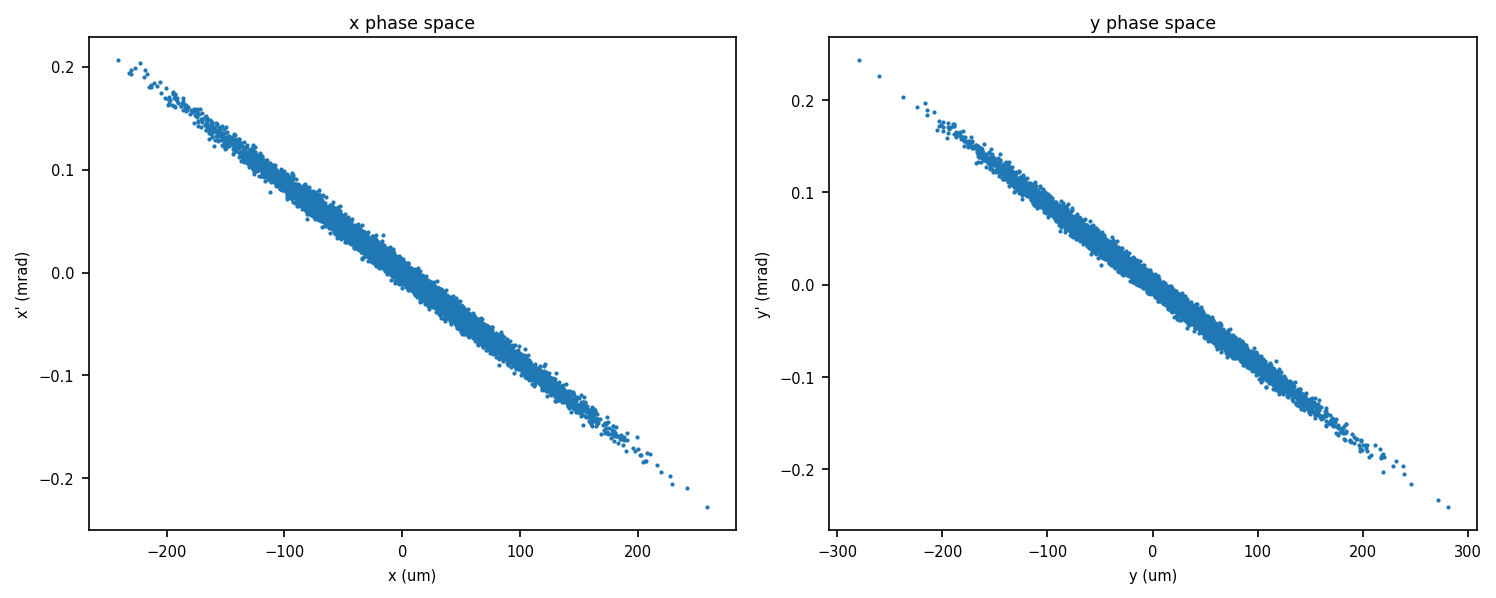

In [3]:
# Create the electron beam
beta = 0.10   # Waist beta function in (m)
waist = -0.36 # Vacuum waist position (m)
gamma = 20000 # Beam relativistic Lorentz factor
betaBeam = beta+(-ramp_zl-waist)**2/beta
alphaBeam = (ramp_zl+waist)/beta
electronParams = {
    'name' : 'TestBeam',
    'path' : path,
    'load' : False,
    'N' : 10000,
    'gamma' : gamma,
    'emittance' : 7e-6,
    'betax' : betaBeam,
    'betay' : betaBeam,
    'alphax' : alphaBeam,
    'alphay' : alphaBeam,
    'sigmaz' : 5e-6,
    'dE' : 0.01
}

beam = electronbeam.GaussianElectronBeam(electronParams)
beam.plot_current_phase()

In [4]:
dumpPer = 1
interactions.electron_plasma(beam, plasmaDen, z, dumpPer, 4)
m = int(Nz/dumpPer)
beam_z = np.linspace(0.0, 2*ramp_zl+flattop, m)
beam_ne = interp1d(z, ne)(beam_z*1e6)

Initial emittance: 6.9965 um rad
Final emittance:   7.0020 um rad


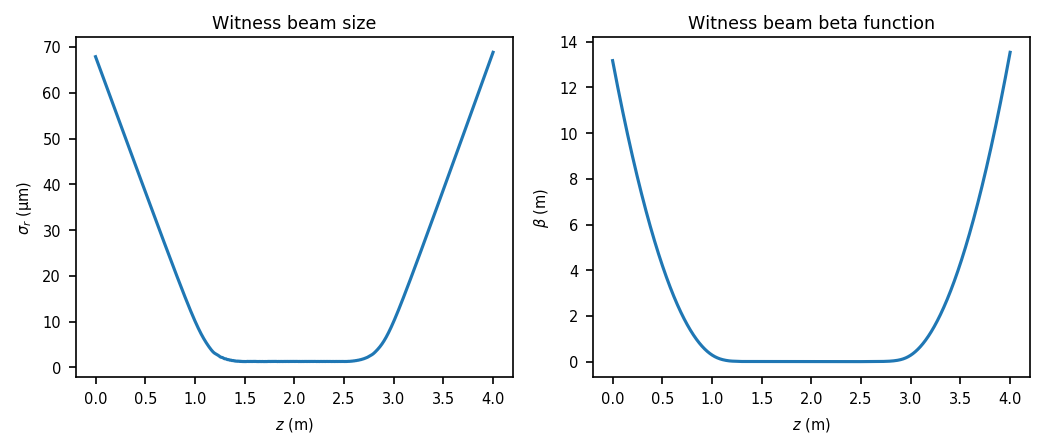

In [5]:
# Check to make sure everything seems correct
beam_sigmar = np.zeros(m, dtype='double')
beam_eps = np.zeros(m, dtype='double')
for i in range(m):
    beam_sigmar[i] = np.average(beam.get_sigmar(i))
    beam_eps[i] = np.average(beam.get_emittance_n(i))
beam_beta = (beam_sigmar)**2 / beam_eps * gamma
print('Initial emittance: %0.4f um rad' % (beam_eps[0]*1e6))
print('Final emittance:   %0.4f um rad' % (beam_eps[m-1]*1e6))

plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0,0])
plt.plot(beam_z, beam_sigmar*1e6)
plt.title('Witness beam size')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\sigma_r$ ($\mathrm{\mu m}$)')

plt.subplot(gs[0,1])
plt.plot(beam_z, beam_beta)
plt.title('Witness beam beta function')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (m)')

plt.tight_layout()
plt.show()

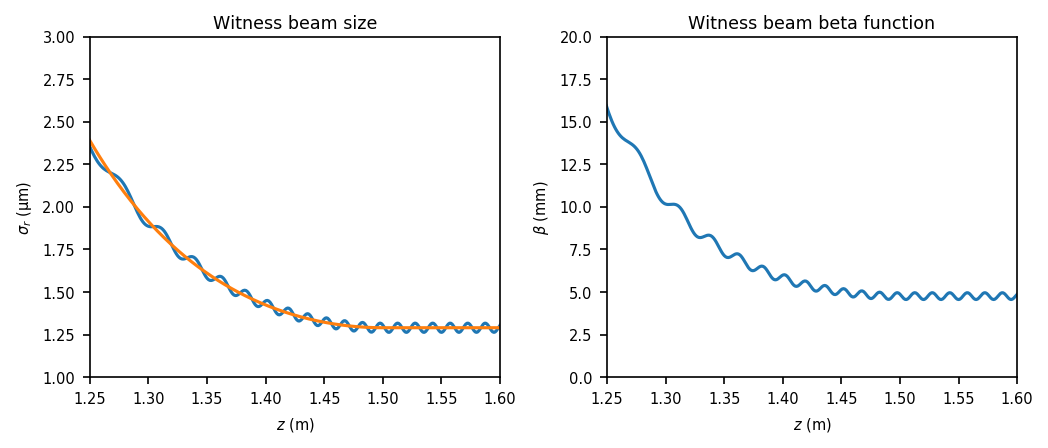

In [18]:
# Lets look at the region right before the ramp more carefully
eps0 = const.physical_constants['electric constant'][0]
me = const.physical_constants['electron mass'][0]
e = const.physical_constants['elementary charge'][0]
c = const.physical_constants['speed of light in vacuum'][0]
betaM  = np.sqrt(c*np.sqrt(me*eps0/beam_ne/1e23/e**2)*np.sqrt(2*gamma))
sigmaM = np.sqrt(c*np.sqrt(me*eps0/beam_ne/1e23/e**2)*1e6*np.sqrt(2*gamma)*7.0/gamma)

plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0,0])
plt.plot(beam_z, beam_sigmar*1e6)
plt.plot(beam_z, sigmaM)
plt.title('Witness beam size')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\sigma_r$ ($\mathrm{\mu m}$)')
plt.xlim([1.25, 1.6])
plt.ylim(1, 3)

plt.subplot(gs[0,1])
plt.plot(beam_z, beam_beta*1e3)
plt.plot(beam_z, betaM*1e3)
plt.title('Witness beam beta function')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (mm)')
plt.xlim([1.25, 1.6])
plt.ylim(0, 20)

plt.tight_layout()
plt.show()